In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Other
# ==============================================================================
import warnings
#warnings.filterwarnings('ignore')

In [2]:
data_dir = r"../data/processed_data/total_data.csv"
data = pd.read_csv(data_dir)
data.Date = pd.to_datetime(data.Date)
data = data.set_index('Date',drop=False)
data = data.asfreq('H',method='ffill')#.mean()

data = data.sort_index()

In [3]:
train_len = round(len(data) * 0.6)
val_len = round(len(data) * 0.2)
print(f"Data training size: {train_len}")
print(f"Data validation and test size: {val_len}")

Data training size: 33292
Data validation and test size: 11097


In [4]:
data_train = data.iloc[: train_len, :]
data_val   = data.iloc[train_len:train_len+val_len, :]
data_test  = data.iloc[train_len+val_len:, :]

In [5]:
data_test

,Date,actual_temp,wind_spd_tia_1,dew_point_tia_1,temp_tia_1,wind_spd_tcc_1,dew_point_tcc_1,temp_tcc_1,wind_spd_b_1,dew_point_b_1,...,wind_dir_tcc_1_N,wind_dir_tcc_1_NE,wind_dir_tcc_1_NNE,wind_dir_b_1_N,wind_dir_b_1_NE,wind_dir_b_1_NNE,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-23 14:00:00,2021-01-23 14:00:00,-4.2,32.0,-14.9,-5.3,26.0,-13.5,-4.2,31.0,-14.1,...,0,0,1,0,0,1,1,3,23,5
2021-01-23 15:00:00,2021-01-23 15:00:00,-4.9,34.0,-14.9,-4.8,26.0,-14.4,-4.4,30.0,-13.8,...,0,0,1,0,0,1,1,3,23,5
2021-01-23 16:00:00,2021-01-23 16:00:00,-5.1,27.0,-14.7,-4.9,30.0,-14.6,-4.6,28.0,-13.8,...,0,0,1,0,0,1,1,3,23,5
2021-01-23 17:00:00,2021-01-23 17:00:00,-5.4,27.0,-15.1,-5.2,28.0,-14.0,-4.6,22.0,-13.4,...,0,0,1,0,0,1,1,3,23,5
2021-01-23 18:00:00,2021-01-23 18:00:00,-5.9,29.0,-15.5,-6.4,21.0,-14.7,-5.3,28.0,-13.1,...,0,0,1,0,0,1,1,3,23,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-30 19:00:00,2022-04-30 19:00:00,12.1,9.0,-8.3,11.2,5.0,-7.3,10.7,16.0,-7.4,...,0,0,1,0,0,1,4,17,30,5
2022-04-30 20:00:00,2022-04-30 20:00:00,11.3,4.0,-9.8,11.1,5.0,-5.2,9.8,8.0,-7.2,...,1,0,0,0,0,1,4,17,30,5
2022-04-30 21:00:00,2022-04-30 21:00:00,10.8,8.0,-9.2,9.9,21.0,-2.4,8.9,7.0,-8.3,...,1,0,0,0,0,1,4,17,30,5


In [6]:
print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-01-01 01:00:00 --- 2019-10-19 04:00:00  (n=33292)
Dates validacion : 2019-10-19 05:00:00 --- 2021-01-23 13:00:00  (n=11097)
Dates test       : 2021-01-23 14:00:00 --- 2022-04-30 23:00:00  (n=11098)


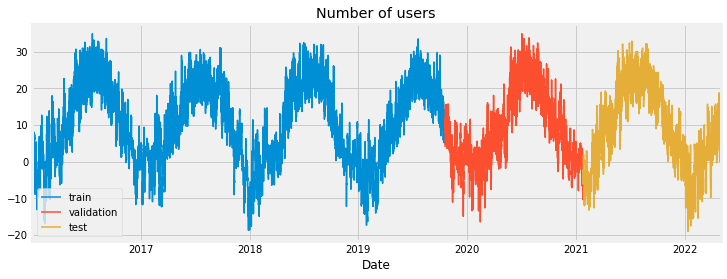

In [7]:
fig, ax = plt.subplots(figsize=(11, 4))
data_train['actual_temp'].plot(ax=ax, label='train')
data_val['actual_temp'].plot(ax=ax, label='validation')
data_test['actual_temp'].plot(ax=ax, label='test')
ax.set_title('Number of users')
ax.legend();

## XGBoost

In [8]:
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'objective': 'reg:squarederror', 'base_score': None

In [9]:
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = data.iloc[:train_len+val_len]['actual_temp'], # Train and validation data
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(data_train)), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

Number of models compared: 48


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [17:29<00:00, 262.28s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 11.492881565374336



In [10]:
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",11.492882,0.1,5.0,100.0
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",11.705332,0.1,5.0,100.0
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",11.844934,0.1,10.0,100.0
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",11.945352,0.1,3.0,500.0
43,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",12.058565,0.1,3.0,500.0
45,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",12.119262,0.1,5.0,500.0
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",12.176811,0.1,5.0,500.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",12.185698,0.1,5.0,500.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",12.458238,0.1,5.0,100.0
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",12.500089,0.1,3.0,500.0


In [11]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['actual_temp'],
    initial_train_size = len(data.iloc[:train_len+val_len]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 13.957427514357638


In [12]:
predictions

,pred
2021-01-23 14:00:00,-4.291949
2021-01-23 15:00:00,-4.159596
2021-01-23 16:00:00,-4.136375
2021-01-23 17:00:00,-4.165651
2021-01-23 18:00:00,-4.199129
...,...
2022-04-30 19:00:00,9.683623
2022-04-30 20:00:00,9.157670
2022-04-30 21:00:00,8.591185
2022-04-30 22:00:00,8.136800


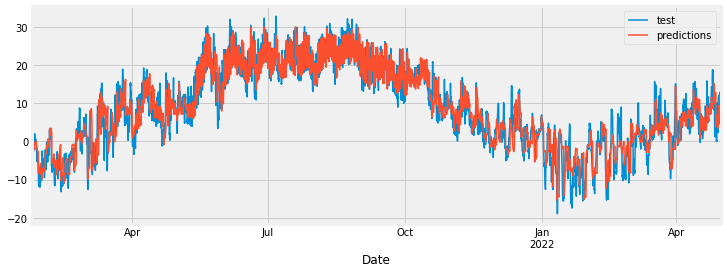

In [13]:
ig, ax = plt.subplots(figsize=(11, 4))
data_test['actual_temp'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

## Exogenous Features

In [14]:
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

exogenous_features = ['wind_spd_tia_1', 'dew_point_tia_1', 'temp_tia_1',
       'wind_spd_tcc_1', 'dew_point_tcc_1', 'temp_tcc_1', 'wind_spd_b_1',
       'dew_point_b_1', 'temp_b_1', 'dew_point_tc_1', 'actual_temp_1',
       'wind_chill_tia_1', 'weather_label_tia_1_Clear',
       'weather_label_tia_1_Cloudy', 'weather_label_tia_1_Fog',
       'weather_label_tia_1_Rain', 'weather_label_tia_1_Snow',
       'wind_dir_tia_1_N', 'wind_dir_tia_1_NE', 'wind_dir_tia_1_NNE',
       'wind_dir_tcc_1_N', 'wind_dir_tcc_1_NE', 'wind_dir_tcc_1_NNE',
       'wind_dir_b_1_N', 'wind_dir_b_1_NE', 'wind_dir_b_1_NNE', 'month',
       'week', 'day', 'day_of_week','hmdx_tia_1','solar_rad_1']

# Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = data.iloc[:train_len+val_len]['actual_temp'], # Train and validation data
        exog               = data.iloc[:train_len+val_len][exogenous_features],
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(data_train)), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

Number of models compared: 48


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [20:31<00:00, 307.76s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.5805085756789377



In [15]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['actual_temp'],
    exog               = data[exogenous_features],
    initial_train_size = len(data.iloc[:train_len+val_len]),
    fixed_train_size   = False,
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
    )

print(f"Backtest error: {metric}")

Backtest error: 0.740153947686808


In [16]:
# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importance()
importance

,feature,importance
0,lag_1,0.167117
1,lag_2,0.000073
2,lag_3,0.000093
3,lag_4,0.000067
4,lag_5,0.000069
5,lag_6,0.000054
6,lag_7,0.000050
7,lag_8,0.000063
8,lag_9,0.000062
9,lag_10,0.000067


## LightGBM


In [17]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=42),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-08-08 11:05:42 
Last fit date: None 
Skforecast version: 0.4.3 

In [18]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

exogenous_features = ['wind_spd_tia_1', 'dew_point_tia_1', 'temp_tia_1',
       'wind_spd_tcc_1', 'dew_point_tcc_1', 'temp_tcc_1', 'wind_spd_b_1',
       'dew_point_b_1', 'temp_b_1', 'dew_point_tc_1', 'actual_temp_1',
       'wind_chill_tia_1', 'weather_label_tia_1_Clear',
       'weather_label_tia_1_Cloudy', 'weather_label_tia_1_Fog',
       'weather_label_tia_1_Rain', 'weather_label_tia_1_Snow',
       'wind_dir_tia_1_N', 'wind_dir_tia_1_NE', 'wind_dir_tia_1_NNE',
       'wind_dir_tcc_1_N', 'wind_dir_tcc_1_NE', 'wind_dir_tcc_1_NNE',
       'wind_dir_b_1_N', 'wind_dir_b_1_NE', 'wind_dir_b_1_NNE', 'month',
       'week', 'day', 'day_of_week','hmdx_tia_1','solar_rad_1']

# Lags used as predictors
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.iloc[:train_len+val_len]['actual_temp'],
                        exog               = data.iloc[:train_len+val_len][exogenous_features],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                        )

Number of models compared: 24


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:21<00:00, 40.77s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.6036064641981651



In [19]:
# Results grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.603606,0.10,5.0,500.0
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.611826,0.10,10.0,500.0
21,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.634412,0.10,5.0,500.0
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.637412,0.10,10.0,100.0
23,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.641508,0.10,10.0,500.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.665685,0.10,5.0,100.0
22,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.679026,0.10,10.0,100.0
20,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.703992,0.10,5.0,100.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.707660,0.01,10.0,500.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.731134,0.01,5.0,500.0


In [20]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['actual_temp'],
    exog               = data[exogenous_features],
    initial_train_size = len(data.iloc[:train_len+val_len]),
    fixed_train_size   = False,
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
    )

print(f"Backtest error: {metric}")

Backtest error: 0.8317246524572283


In [2]:
# Feature importance
# ==============================================================================
importance = forecaster.get_feature_importance()
importance = importance.sort_values(by='importance',ascending=False)
importance

NameError: name 'forecaster' is not defined

## CatBoost

In [22]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x0000028E7F4D19C8> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-08-08 11:07:10 
Last fit date: None 
Skforecast version: 0.4.3 

In [23]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.iloc[:train_len+val_len]['actual_temp'],
                        exog               = data.iloc[:train_len+val_len][exogenous_features],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                        )

Number of models compared: 24


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [08:50<00:00, 265.13s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 71 72 73] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 0.6012666273492582



In [24]:
# Results grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
23,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.601267,0.10,10.0,500.0
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.627933,0.10,10.0,500.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.644489,0.10,5.0,500.0
21,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.670498,0.10,5.0,500.0
22,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.723556,0.10,10.0,100.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.727865,0.10,3.0,500.0
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.751986,0.10,10.0,100.0
17,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.760181,0.01,10.0,500.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.781755,0.01,10.0,500.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.827967,0.01,5.0,500.0


In [26]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['actual_temp'],
    exog               = data[exogenous_features],
    initial_train_size = len(data.iloc[:train_len+val_len]),
    fixed_train_size   = False,
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
    )

print(f"Backtest error: {metric}")

Backtest error: 0.775011964069268


In [29]:
# Feature importance
# ==============================================================================
importance = forecaster.get_feature_importance()
importance

,feature,importance
0,lag_1,22.634666
1,lag_2,6.522126
2,lag_3,3.067161
3,lag_23,0.425310
4,lag_24,0.732319
5,lag_25,0.315389
6,lag_71,0.192599
7,lag_72,0.695991
8,lag_73,0.400076
9,wind_spd_tia_1,0.329395


In [42]:
importance = importance.sort_values(by='importance',ascending=False)
importance

,feature,importance
0,lag_1,22.634666
19,actual_temp_1,14.755645
11,temp_tia_1,12.072817
20,wind_chill_tia_1,9.611763
17,temp_b_1,7.755628
39,hmdx_tia_1,6.646082
1,lag_2,6.522126
14,temp_tcc_1,3.670338
2,lag_3,3.067161
40,solar_rad_1,2.624992


[]

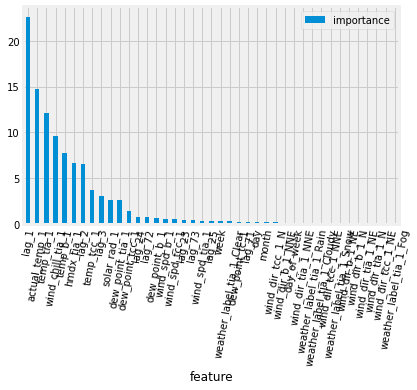

In [41]:
importance.plot.bar(x='feature',y='importance',rot=80)
plt.plot()